At this repository, we did explanatory data analyses, which helped us to investigate some exciting patterns or to illuminate any anomalies and also helped to do summary statistics which we present graphically. 

## Import and request the data

In [2]:
import numpy as np
import pandas
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# create a client instance of the library
elastic_client = Elasticsearch(timeout=60, max_retries=10, retry_on_timeout=True)
elastic_client.cluster.health(wait_for_status='yellow', request_timeout=55)

{'cluster_name': 'es-docker-cluster',
 'status': 'yellow',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 15,
 'active_shards': 15,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 2,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 88.23529411764706}

In [3]:
#https://kb.objectrocket.com/elasticsearch/how-to-use-elasticsearch-data-using-pandas-in-python-349
response = elastic_client.search(
    index='opensea',
    body={},
    size=1
)
response

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 1.0,
  'hits': [{'_index': 'opensea',
    '_type': '_doc',
    '_id': 'PY4SOX0BHA1xYJHHtcXY',
    '_score': 1.0,
    '_source': {'os_id': 106803514,
     'token_id': '6310487523167464038236848917657863475338708156820240490236251522907754201089',
     'name': 'Cool Dog #243',
     'description': None,
     'external_link': None,
     'permalink': 'https://opensea.io/assets/0x495f947276749ce646f68ac8c248420045cb7b5e/6310487523167464038236848917657863475338708156820240490236251522907754201089',
     'collection_slug': 'cool-dogs-1',
     'collection_created': '2021-08-08T04:52:47.684730',
     'collection_description': 'Cool Dogs is a limited series of 1/1 NFTs, a collection of hand drawn parody avatars. \nOnly 333 will be created, then any wallet holding 2 or more dogs will be airdropped an exclusive puppy from Cool 

In [4]:
elastic_docs = []
s = Search(using=elastic_client, index="opensea")
s = s.source(excludes=[
    "last_sale_orginal", "image_original_url", "image_preview_url", "image_url", "os_id",
    'animation_url', '@scraped', 'animation_original_url', 
    'permalink', 'sell_order_usd', 'buy_order_usd'
])
#s = s.extra(track_total_hits=True)
#s = s.extra(from_=0, size=10000)
#s = s.sort({"@latest_sale_timestamp" : {"order" : "asc"}}) # too slow :(

#response = s.execute()
# declare a new list for the Elasticsearch documents
# nested inside the API response object
#elastic_docs.extend(response.to_dict()["hits"]["hits"])

i = 0
for hit in s.scan():
    i += 1
    if i <= 200000:
        continue
    id = hit.meta.id
    obj = hit.to_dict()
    obj["id"] = id
    elastic_docs.append(obj)
    #if i > 1000000:
    #    break
    

# print number of documents
print("documents returned:", len(elastic_docs))
# print(response.hits.total)

documents returned: 1786870


In [5]:
# too slow!!!
#s = Search(using=elastic_client, index="opensea") \
#    .filter("exists", field="latest_sale_usd") \
#    .filter("exists", field="preview_path") \
#    .exclude("match", is_animation=True)

In [8]:
for hit in elastic_docs[0:10]:
    print(hit["name"])

Rug Radio Membership Pass
Woofpack #1398
Lil Pudgy #2168
raisingcapital.eth
Cryptorasta #04798
CROAKZ 4323
Metapreneurs #1
Bored Bigfoot Billionaires #1
Meta Legend #4782
Psychedelics Anonymous Genesis #24


In [9]:
# create a Pandas DataFrame array from the fields dict
elastic_df = pandas.DataFrame(elastic_docs)

print('elastic_df:', type(elastic_df), "\n")

elastic_df: <class 'pandas.core.frame.DataFrame'> 



In [5]:
#elastic_df = elastic_df[-200000]

In [10]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786870 entries, 0 to 1786869
Data columns (total 28 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   creator                  object 
 1   latest_sale_token_value  float64
 2   collection_created       object 
 3   latest_sale_usd          float64
 4   description              object 
 5   is_animation             bool   
 6   @latest_sale_timestamp   object 
 7   external_link            object 
 8   token_id                 object 
 9   name                     object 
 10  collection_slug          object 
 11  collection_description   object 
 12  contract_scheme          object 
 13  latest_sale_token        object 
 14  id                       object 
 15  instagram                object 
 16  twitter                  object 
 17  img_path                 object 
 18  twitter_follower         float64
 19  preview_path             object 
 20  telegram_follower        float64
 21  telegram

In [11]:
del elastic_docs

## EDA
### Feature engineering and dealing with missing values

In [7]:
elastic_df.head(10)

,creator,latest_sale_token_value,collection_created,latest_sale_usd,description,is_animation,@latest_sale_timestamp,external_link,token_id,name,...,instagram,twitter,img_path,twitter_follower,preview_path,telegram_follower,telegram,instagram_follower,medium,medium_follower
0,0xb40197806a07b3b2dbb4b43d255ef32c328d44ab,0.0320,2021-12-22T16:04:44.113117,126.311360,A Rug Radio Membership Pass is step one in get...,False,2021-12-23T11:49:57,https://www.rug.fm/,4532,Rug Radio Membership Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WoofpackNFT,0.0195,2021-12-06T05:59:48.729482,76.970985,"WoofPack is a generative NFT collection of 7,7...",False,2021-12-23T11:50:31,None,1398,Woofpack #1398,...,freedomwoofpack,https://cdn.syndication.twimg.com/widgets/foll...,C:\nft_data\img\e-sh530Bt_K6OZC-XA9q_noext.png,12770.0,C:\nft_data\preview\e-sh530Bt_K6OZC-XA9q_noext...,NaN,NaN,NaN,NaN,NaN
2,PudgyPenguinsKing,0.0180,2021-12-19T17:19:18.712729,71.050140,"Lil Pudgys are a collection of 22,222 randomly...",False,2021-12-23T11:50:31,None,2168,Lil Pudgy #2168,...,NaN,https://cdn.syndication.twimg.com/widgets/foll...,C:\nft_data\img\eesh530Bt_K6OZC-XA9U_noext.png,47722.0,C:\nft_data\preview\eesh530Bt_K6OZC-XA9U_noext...,NaN,NaN,NaN,NaN,NaN
3,0x4fe4e666be5752f1fdd210f4ab5de2cc26e3e0e8,0.0490,2019-05-08T21:59:36.282454,193.414270,"raisingcapital.eth, an ENS name.",False,2021-12-23T11:50:31,https://app.ens.domains/name/raisingcapital.eth,6303362342123076358801682011385576897676816590...,raisingcapital.eth,...,NaN,https://cdn.syndication.twimg.com/widgets/foll...,C:\nft_data\img\fush530Bt_K6OZC-Xw8O.svg,137809.0,NaN,NaN,NaN,NaN,NaN,NaN
4,CryptoRastas_Team,0.0200,2021-08-29T20:17:31.880439,78.944600,Cryptorasta #04798 - Shannon Stone is a doctor...,False,2021-12-23T11:50:31,https://cryptorastas.com,4798,Cryptorasta #04798,...,cryptorastas,https://cdn.syndication.twimg.com/widgets/foll...,C:\nft_data\img\hush530Bt_K6OZC-Xw_b_noext.png,5648.0,C:\nft_data\preview\hush530Bt_K6OZC-Xw_b_noext...,NaN,NaN,NaN,NaN,NaN
5,0x92bce497efe4332a8f611004f67e14093b5d0e8c,0.0540,2021-12-11T22:01:00.752970,213.150420,"A collection of 6,969 unique CROAKZ that vibe ...",False,2021-12-23T11:50:20,https://croakz.io,4323,CROAKZ 4323,...,croakz_,https://cdn.syndication.twimg.com/widgets/foll...,C:\nft_data\img\j-sh530Bt_K6OZC-ZA99_noext.png,17606.0,C:\nft_data\preview\j-sh530Bt_K6OZC-ZA99_noext...,NaN,NaN,NaN,NaN,NaN
6,TheMetapreneurs,0.1400,2021-12-22T15:31:21.596017,552.612200,"The Metapreneurs is a collection of 11,111 Hig...",False,2021-12-23T11:49:42,None,2174,Metapreneurs #1,...,themetapreneurs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Bored-Bigfoot-Billionaires,0.0990,2021-12-10T02:53:56.221863,390.775770,The Bored Bigfoot Billionaires is a collection...,False,2021-12-23T11:50:13,None,1161,Bored Bigfoot Billionaires #1,...,boredbigfootsnft,https://cdn.syndication.twimg.com/widgets/foll...,NaN,7372.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Meta-Legends,0.3300,2021-11-24T10:38:46.735735,1302.585900,12345 unique legends to save humanity - A lege...,False,2021-12-23T11:50:31,None,4782,Meta Legend #4782,...,meta.legends/,https://cdn.syndication.twimg.com/widgets/foll...,C:\nft_data\img\gOsh530Bt_K6OZC-Xw8i_noext.png,50801.0,C:\nft_data\preview\gOsh530Bt_K6OZC-Xw8i_noext...,NaN,NaN,NaN,NaN,NaN
9,Psychedelics-Anonymous,0.6000,2021-12-22T21:00:33.484429,2381.928000,"At the zero hour, we gather in the darkness se...",False,2021-12-23T03:19:36,None,24,Psychedelics Anonymous Genesis #24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print("Animations in Dataset", len(elastic_df[elastic_df.is_animation == True]) / len(elastic_df) * 100, "%")

Animations in Dataset 11.96029929429673 %


In [13]:
len(elastic_df[elastic_df.is_animation == True])

213715

In [14]:
elastic_df = elastic_df[elastic_df.is_animation == False]

In [15]:
len(elastic_df[elastic_df.is_animation == True])

0

In [16]:
# head doesn't show all columns - so I use this here:
elastic_df.iloc[541]

creator                                                   PixelVaultDeployer
latest_sale_token_value                                                0.225
collection_created                                2021-05-11T01:08:43.634595
latest_sale_usd                                                     895.9095
description                PUNKS Comic Issue #2: Our tale resumes as Cour...
is_animation                                                           False
@latest_sale_timestamp                                   2021-12-23T04:15:02
external_link                                         https://punkscomic.com
token_id                                                               11092
name                                               PUNKS 2: X Marks the Drop
collection_slug                                                  punks-comic
collection_description     Meet the PUNKS! Everyone’s favorite misfit cre...
contract_scheme                                                       ERC721

In [17]:
elastic_df['contract_scheme'].value_counts()
# cryptopunks & ERC721 = 1
# ERC-1155 can use a single contract to make various types of NFTs = 2
# NaN = 3

ERC721         1428766
ERC1155         115624
CRYPTOPUNKS        158
Name: contract_scheme, dtype: int64

In [18]:
elastic_df['latest_sale_token'].value_counts()

ETH       1510796
WETH        31410
MANA          688
ASH           213
USDC          185
SAND          143
GALA          122
GSK            55
SHIB           55
DAI            51
REVV           29
VOLT           22
ATRI           21
CUBE           12
ELAND           8
BZN             5
NCR             4
TRSH            4
WHALE           4
CHIZ            3
SILA            3
MATIC           3
RARI            2
ENJ             2
DUST            2
VSF             2
0xBTC           2
WBTC            1
BNT             1
MM              1
ARCONA          1
ERN             1
CHONK           1
RARE            1
MORK            1
WTF             1
Name: latest_sale_token, dtype: int64

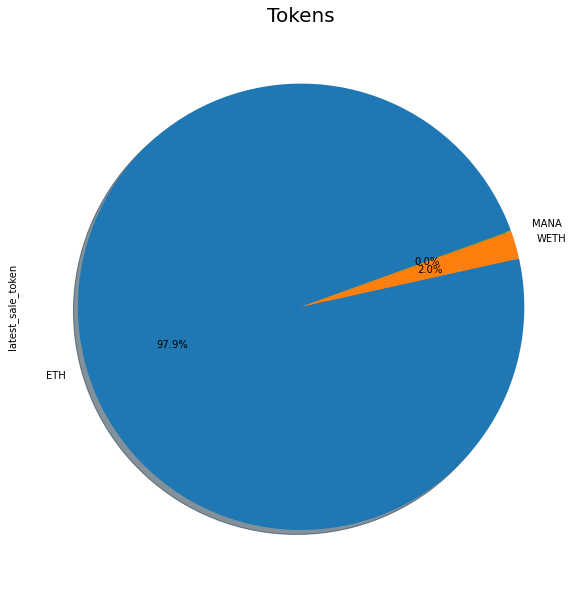

In [19]:
elastic_df['latest_sale_token'].value_counts()[:3].plot.pie(figsize=(10,15), shadow=True, 
                                                 startangle=20, autopct='%1.1f%%', fontsize=10)
plt.title("Tokens", fontsize=20)
plt.show()

All NFTs were sols with Etherium. 

In [16]:
#elastic_df.columns

Index(['id', 'creator', 'collection_created', 'latest_sale_usd', 'description',
       '@latest_sale_timestamp', 'external_link', 'twitter', 'token_id',
       'img_path', 'twitter_follower', 'name', 'collection_slug',
       'preview_path', 'collection_description', 'instagram',
       'telegram_follower', 'telegram', 'instagram_follower'],
      dtype='object')

In [9]:
#elastic_df.drop(['token_id'], inplace=True, axis=1)

In [82]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109300 entries, 0 to 109299
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   creator                  107040 non-null  object 
 1   token_id                 109300 non-null  object 
 2   collection_created       109300 non-null  object 
 3   latest_sale_usd          108098 non-null  float64
 4   name                     103832 non-null  object 
 5   description              88294 non-null   object 
 6   collection_slug          109300 non-null  object 
 7   is_animation             109300 non-null  bool   
 8   @latest_sale_timestamp   109300 non-null  object 
 9   collection_description   108015 non-null  object 
 10  external_link            33883 non-null   object 
 11  id                       109300 non-null  object 
 12  instagram                41836 non-null   object 
 13  twitter                  23847 non-null   object 
 14  twit

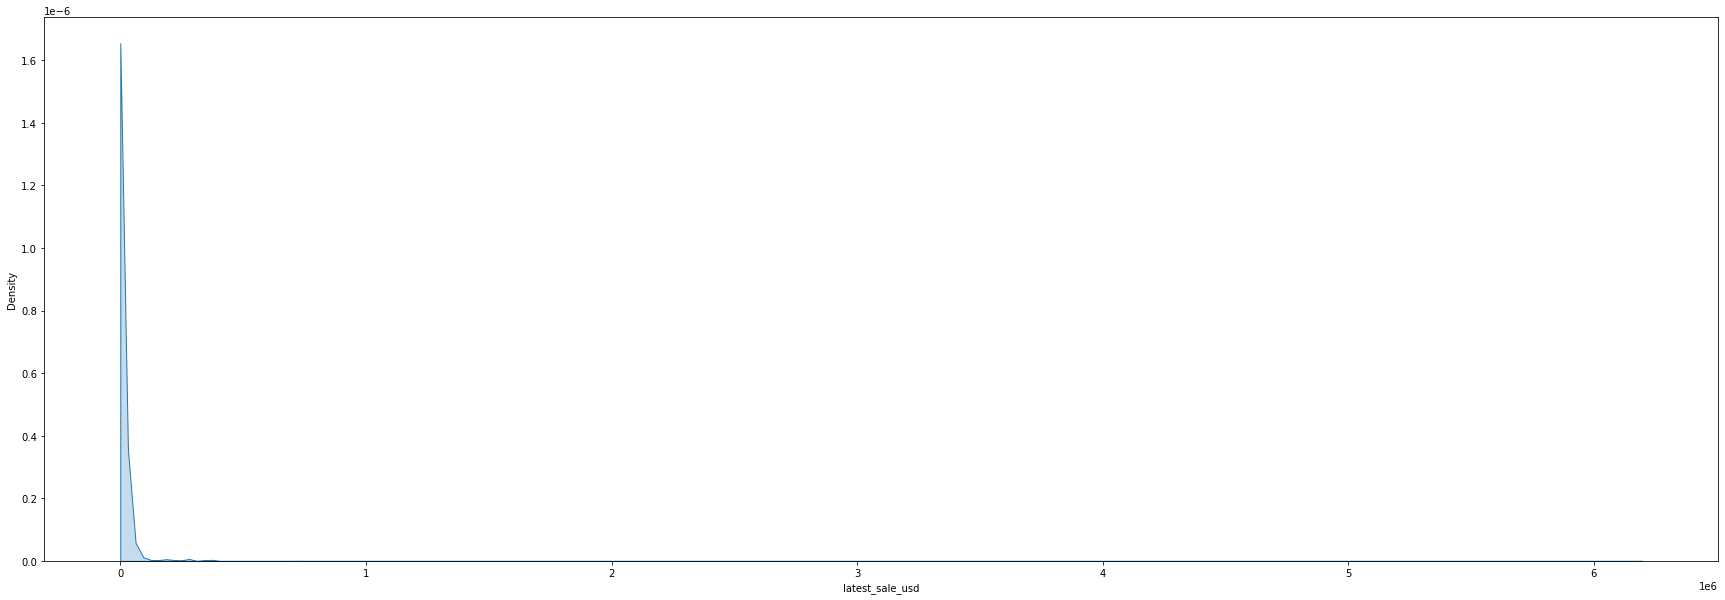

In [20]:
plt.figure(figsize = (30,10))
sns.kdeplot(elastic_df['latest_sale_usd'], bw_method=0.01, fill = True)
plt.show()

Here we take a look at price distribution around the dataset. And then we investigate the time when assets were sold. 

In [16]:
elastic_df['@latest_sale_timestamp']

0          2021-12-23T11:49:57
1          2021-12-23T11:50:31
2          2021-12-23T11:50:31
3          2021-12-23T11:50:31
4          2021-12-23T11:50:31
                  ...         
1075468    2022-01-16T17:44:38
1075469    2022-01-16T17:44:47
1075470    2022-01-16T17:44:54
1075471    2022-01-16T17:44:54
1075472    2022-01-16T17:44:54
Name: @latest_sale_timestamp, Length: 965049, dtype: object

In [17]:
import datetime
from datetime import datetime

First look at NAs.

In [18]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
medium_follower,965044,0.999995
medium,965044,0.999995
instagram_follower,964190,0.999110
telegram_follower,935436,0.969315
telegram,933169,0.966965
external_link,723959,0.750178
instagram,565581,0.586065
twitter_follower,462482,0.479232
twitter,453304,0.469721
preview_path,291853,0.302423


In [19]:
elastic_df = elastic_df[elastic_df['@latest_sale_timestamp'].isna() == False]

In [20]:
elastic_df['sale_time'] = elastic_df.apply(lambda row: 
                                      datetime.fromisoformat(row['@latest_sale_timestamp']).time().hour, axis=1)

In [21]:
elastic_df['sale_time'][150000]

7

In [22]:
elastic_df.drop(['@latest_sale_timestamp'], inplace=True, axis=1)

In [29]:
elastic_df['collection_created']

0         2021-12-25T05:04:41.533646
1         2021-07-16T21:40:10.961766
2         2021-12-25T05:04:41.533646
3         2021-12-08T21:50:29.419833
4         2021-12-31T00:01:50.421578
                     ...            
199996    2021-12-31T11:51:17.645610
199997    2022-01-08T10:33:44.755894
199998    2021-12-12T00:45:55.433020
199999    2022-01-08T10:46:59.008593
200000    2022-01-09T04:35:18.118736
Name: collection_created, Length: 183426, dtype: object

In [23]:
elastic_df['collection_created_year'] = elastic_df.apply(lambda row: 
                                      datetime.fromisoformat(row['collection_created']).year, axis=1)

In [31]:
elastic_df['collection_created_year']

0         2021
1         2021
2         2021
3         2021
4         2021
          ... 
199996    2021
199997    2022
199998    2021
199999    2022
200000    2022
Name: collection_created_year, Length: 183426, dtype: int64

The year when assets were created. 

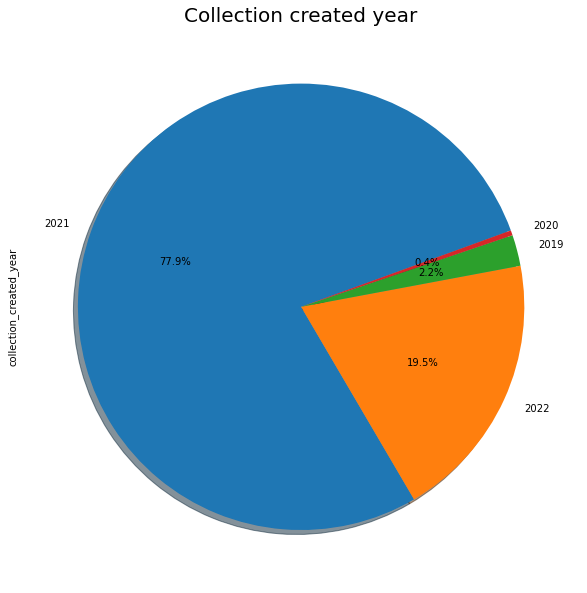

In [24]:
elastic_df['collection_created_year'].value_counts()[:10].plot.pie(figsize=(10,15), shadow=True, 
                                                 startangle=20, autopct='%1.1f%%', fontsize=10)
plt.title("Collection created year", fontsize=20)
plt.show()

In [25]:
elastic_df.drop(['collection_created'], inplace=True, axis=1)

In [26]:
elastic_df['latest_sale_token_value'].value_counts()

0.100000    30819
0.050000    22517
0.150000    19977
0.200000    17979
0.020000    17410
            ...  
0.118444        1
5.130000        1
0.094406        1
1.121300        1
1.268900        1
Name: latest_sale_token_value, Length: 17295, dtype: int64

In [27]:
elastic_df['creator'].value_counts().head()

Psychedelics-Anonymous                        11581
0x579ab5a6eee1139b406710ddb03bfad4ad62142a     8777
0x25025e203f892f50c357bc0703eaf258879a8def     7600
BasicBoredApeClubDeployer                      7452
MTGTEAM                                        7007
Name: creator, dtype: int64

In [28]:
len(elastic_df['collection_slug'].value_counts()) #name of the collection, short name of any collection

14487

In [29]:
elastic_df['collection_slug'].value_counts().head()

chainfaces-arena             8803
rug-radio-membership-pass    7586
basicboredapeclub            7458
morethangamersnftmtg         7019
primeapeplanetpap            6366
Name: collection_slug, dtype: int64

In [30]:
elastic_df.drop(['token_id', 'external_link'], inplace=True, axis=1)

In [31]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 965033 entries, 0 to 1075472
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   creator                  928567 non-null  object 
 1   latest_sale_token_value  935774 non-null  float64
 2   latest_sale_usd          955403 non-null  float64
 3   description              778348 non-null  object 
 4   is_animation             965033 non-null  bool   
 5   name                     890896 non-null  object 
 6   collection_slug          965033 non-null  object 
 7   collection_description   961235 non-null  object 
 8   contract_scheme          936426 non-null  object 
 9   latest_sale_token        935774 non-null  object 
 10  id                       965033 non-null  object 
 11  instagram                399466 non-null  object 
 12  twitter                  511737 non-null  object 
 13  img_path                 723256 non-null  object 
 14  twi

In [38]:
elastic_df = elastic_df.rename(columns={'latest_sale_token':'sale_token'})
elastic_df = elastic_df.rename(columns={'latest_sale_token_value':'price_crypto'})
elastic_df = elastic_df.rename(columns={'latest_sale_usd':'sale_usd'})
elastic_df = elastic_df.rename(columns={'collection_slug':'collection_name'})

Type of scheme creators use to create an asset.

In [39]:
elastic_df['contract_scheme'].value_counts()

ERC721         872160
ERC1155         64178
CRYPTOPUNKS        88
Name: contract_scheme, dtype: int64

In [40]:
elastic_df['contract_scheme'] = elastic_df['contract_scheme'].astype('category')

In [41]:
elastic_df['contract_scheme'] = elastic_df['contract_scheme'].cat.rename_categories({'ERC721': 1, 'ERC1155': 2, 'CRYPTOPUNKS': 3 })

## NaNs

In [42]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
medium_follower,965028,0.999995
medium,965028,0.999995
instagram_follower,964174,0.999110
telegram_follower,935423,0.969317
telegram,933156,0.966968
instagram,565567,0.586060
twitter_follower,462473,0.479230
twitter,453296,0.469721
preview_path,291844,0.302419
img_path,241777,0.250538


Due to the high amount of empty values in the columns "telegram_follower" and "telegram" & "medium" it was made a decidsion to drop these columns.

In [43]:
elastic_df.drop(['telegram_follower', 'telegram', 'medium_follower', 'medium'], inplace=True, axis=1) 

Some rows didn't have the infomation about their price. The reson could be lay either on Opensea or creators or transfars without money invovment. Due to the small amount of such cases I decided to drop them too.

In [44]:
elastic_df = elastic_df[elastic_df['sale_usd'].isna() == False]

In [45]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
instagram_follower,954544,0.999101
instagram,560443,0.586604
twitter_follower,461856,0.483415
twitter,452792,0.473928
preview_path,289975,0.303511
img_path,240316,0.251534
description,185232,0.193878
name,73532,0.076964
creator,36358,0.038055
sale_token,29226,0.030590


After I have dropped some rows I reset indexes because it keeps the indexing from the original data frame.

In [51]:
#elastic_df = elastic_df.reset_index(drop=True)

Dealing with empty rows of 'contract_scheme'. I decided to add one more cat '0' insted empty row. 

In [46]:
elastic_df['contract_scheme'].isna().value_counts()

False    926829
True      28574
Name: contract_scheme, dtype: int64

In [26]:
#elastic_df['contract_scheme'] = elastic_df['contract_scheme'].cat.rename_categories({'None': 0})

In [27]:
#elastic_df['contract_scheme'] = elastic_df['contract_scheme'].cat.add_categories('0')
#elastic_df['contract_scheme'].fillna('0', inplace =True) 

## Empty rows in textual columns

In [47]:
elastic_df['collection_description'].fillna("", inplace = True)

In [48]:
def descriptionFill(row):
    if row['description'] == None:
        return row['collection_description']
    else:
        return row['description']
        

elastic_df['description'] = elastic_df.apply(lambda row : descriptionFill(row), axis = 1)

In [49]:
elastic_df['creator'].fillna("", inplace = True)

In [50]:
elastic_df['sale_token'].value_counts()

ETH       905194
WETH       19882
MANA         441
USDC         152
SAND         131
ASH          110
GALA         104
SHIB          43
DAI           42
ATRI          21
REVV          18
CUBE          11
VOLT           6
WHALE          3
DUST           2
VSF            2
RARI           2
0xBTC          2
MATIC          2
ENJ            2
ARCONA         1
WBTC           1
BNT            1
ELAND          1
CHONK          1
MORK           1
ERN            1
Name: sale_token, dtype: int64

In [51]:
elastic_df['sale_token'].fillna("", inplace = True)

In [52]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
instagram_follower,954544,0.999101
instagram,560443,0.586604
twitter_follower,461856,0.483415
twitter,452792,0.473928
preview_path,289975,0.303511
img_path,240316,0.251534
name,73532,0.076964
price_crypto,29226,0.030590
contract_scheme,28574,0.029908
creator,0,0.000000


In [53]:
#name of one asset
print(elastic_df['name'].value_counts())

Rug Radio Membership Pass    6508
C-01 X                       3893
Exclusive Oxyan #            3712
Caked Apes                   3657
Fyat Lux (Unrevealed)        3185
                             ... 
Doodle Dogs #5806               1
Prime Ape #7390                 1
PHANTA BEAR #6560               1
Doodle Dogs #1283               1
Super Yeti #3471                1
Name: name, Length: 755622, dtype: int64


In [54]:
import re

In [22]:
#def nameNone(row):
#    if row['name'] == None:
#        return 'no name'
#    else:
#        return row['name']
        
#elastic_df['name_try'] = elastic_df.apply(lambda row : nameNone(row), axis = 1)

In [55]:
#unique name = 1/yes (as a rule unique asset has a unique name without numbers or collection's name).
#not unique name = 0/no
def unique_name(row):
    if row['name'] == None: #all missing values are 0, because these names aren't unique
        return 0
    search_number = re.search('#[0-9]', row['name']) #all names with #1234 are also not unique
    if search_number != None:
        return 0
    search_number = re.search('^[0-9]+$', row['name']) #all names with 1234 are also not unique
    if search_number != None:
        return 0
    #comparison of the name of an asset & collection's name. First we need to prepare the text 
    lowercase = row['name'].lower()
    minus = re.compile('[^a-zA-Z]|official')
    minus_case = re.sub(minus, '', lowercase)
    if row['collection_name'] != None:
        slug = row['collection_name'].lower()
        slug_clean = re.sub(minus, '', lowercase)
        if len(slug_clean) > 0 and slug_clean == minus_case:
            return 0
    print(row['collection_name'], row['name'], minus_case)    
    return 1  

In [56]:
elastic_df['unique_asset'] = elastic_df.apply(lambda row : unique_name(row), axis = 1)

inbetweeners #🧸 
n-e-o-n-v-i-b-e ネオン 377 
inbetweeners #🧸 
inbetweeners #🧸 
inbetweeners #🧸 
inbetweeners #🧸 
kimo-animals キショ鳥 
inbetweeners #🧸 
inbetweeners #🧸 
inbetweeners #🧸 
inbetweeners #🧸 
manganiku-japan オシャレ肉 
n-e-o-n-v-i-b-e ネオン 55 
ghost-kidz 11:11  
cryptovoxels 31 이문로 
saintj10 區塊鏈 
eponym 🍆💦🍑 
decentraland 😎 
n-e-o-n-v-i-b-e ネオン 183 
n-e-o-n-v-i-b-e ネオン 16 
typical-tigers # 27 
salviadroid 💤 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
ptcolorgraphs  🏛️ 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
ptcolorgraphs 🌿🥊 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy

redlioneye-gazette 𝐑𝐄𝐃𝐋𝐈𝐎𝐍𝐄𝐘𝐄 𝐆𝐀𝐙𝐄𝐓𝐓𝐄 #𝟐𝟗 
ekimemoourrailsanother 大月駅(リゾートなシーナ・2020) 
social-bees-university # 7962 
typical-tigers # 3541 
typical-tigers # 2423 
typical-tigers # 573 
social-bees-university # 5040 
social-bees-university # 7640 
typical-tigers # 3550 
social-bees-university # 6714 
the34project 04//34 
social-bees-university # 9148 
ruifukeji-collection 跳水 
birds-of-prey-club  # 3909 
typical-tigers # 3397 
social-bees-university # 9040 
the-50s # 19 
typical-tigers # 1588 
typical-tigers # 2533 
typical-tigers # 2268 
typical-tigers # 170 
typical-tigers # 2534 
typical-tigers # 1025 
typical-tigers # 690 
typical-tigers # 772 
typical-tigers # 2874 
typical-tigers # 3260 
typical-tigers # 1189 
typical-tigers # 3452 
typical-tigers # 48 
typical-tigers # 1436 
typical-tigers # 2157 
typical-tigers # 1752 
typical-tigers # 3243 
social-bees-university # 7388 
typical-tigers # 3245 
typical-tigers # 2994 
typical-tigers # 1899 
social-bees-university # 3882 
typical-t

typical-tigers # 884 
social-bees-university # 7888 
social-bees-university # 7622 
social-bees-university # 6424 
typical-tigers # 2434 
the-heist-collection ??? 
typical-tigers # 3617 
social-bees-university # 2174 
typical-tigers # 3191 
aimonstergirls 𝓟𝓻𝓲𝓷𝓬𝓮𝓼𝓼 𝓵𝓪𝓶𝓲𝓪 
typical-tigers # 2432 
typical-tigers # 3524 
social-bees-university # 8472 
social-bees-university # 9524 
social-bees-university # 8476 
social-bees-university # 5954 
the-heist-collection ??? 
social-bees-university # 9526 
typical-tigers # 836 
social-bees-university # 8478 
typical-tigers # 2433 
typical-tigers # 2431 


In [57]:
elastic_df['unique_asset'].value_counts()

0    954378
1      1025
Name: unique_asset, dtype: int64

In [63]:
lowercase = 'Name _Hey-Holaz??! official'.lower()
minus = re.compile('[^a-zA-Z]|official')
minus_case = re.sub(minus, '', lowercase)
print(minus_case)

nameheyholaz


In [58]:
elastic_df['name'].fillna("", inplace = True)

The emty spaces in rows are represented with Nan that has a type float. At the same time this raw consists of str.

In [59]:
# instagram account? yes - 1, no -0
def instAcc(row):
    insta = row['instagram']
    if isinstance(insta, str) and len(insta) > 0:
        return 1
    else:
        return 0
        
elastic_df['instagram_account'] = elastic_df.apply(lambda row : instAcc(row), axis = 1)

In [60]:
elastic_df['instagram_account'].value_counts()

0    560443
1    394960
Name: instagram_account, dtype: int64

In [61]:
elastic_df['instagram'].fillna("", inplace = True)

In [62]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
instagram_follower,954544,0.999101
twitter_follower,461856,0.483415
twitter,452792,0.473928
preview_path,289975,0.303511
img_path,240316,0.251534
price_crypto,29226,0.030590
contract_scheme,28574,0.029908
creator,0,0.000000
unique_asset,0,0.000000
collection_created_year,0,0.000000


In [63]:
#account? yes - 1, no -0
def twitterAcc(row):
    twitt = row['twitter']
    if isinstance(twitt, str) and len(twitt) > 0:
        return 1
    else:
        return 0
        
elastic_df['twitter_account'] = elastic_df.apply(lambda row : twitterAcc(row), axis = 1)

In [64]:
elastic_df['twitter_account'].value_counts()

1    502611
0    452792
Name: twitter_account, dtype: int64

In [65]:
elastic_df['twitter_follower'] = elastic_df['twitter_follower'].fillna(0)

In [66]:
elastic_df['twitter'].fillna("", inplace = True)

In [67]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
instagram_follower,954544,0.999101
preview_path,289975,0.303511
img_path,240316,0.251534
price_crypto,29226,0.030590
contract_scheme,28574,0.029908
creator,0,0.000000
twitter,0,0.000000
instagram_account,0,0.000000
unique_asset,0,0.000000
collection_created_year,0,0.000000


Take a look one more time at textual data

In [69]:
elastic_df['twitter'][288]

'https://cdn.syndication.twimg.com/widgets/followbutton/info.json?screen_names=BoredApeYC'

In [70]:
elastic_df['twitter'] = elastic_df['twitter'].apply(lambda url: url.replace('https://cdn.syndication.twimg.com/widgets/followbutton/info.json?screen_names=',''))

In [71]:
elastic_df['instagram']

0                         
1          freedomwoofpack
2                         
3                         
4             cryptorastas
                ...       
1075468    thetigercubclub
1075469                   
1075470                   
1075471                   
1075472                   
Name: instagram, Length: 955403, dtype: object

In [72]:
elastic_df['creator']

0          0xb40197806a07b3b2dbb4b43d255ef32c328d44ab
1                                         WoofpackNFT
2                                   PudgyPenguinsKing
3          0x4fe4e666be5752f1fdd210f4ab5de2cc26e3e0e8
4                                   CryptoRastas_Team
                              ...                    
1075468    0x221aaec36b78a57081be5541796b544803eb8627
1075469                                     PixelDood
1075470                                 mihaylova_jpg
1075471    0x6681ee66db195a2d2dc7e360fd29a933db785c22
1075472    0x62610ed68fd71cf2935b0c49c96299bd6525badc
Name: creator, Length: 955403, dtype: object

In [73]:
elastic_df['name']

0                    Rug Radio Membership Pass
1                               Woofpack #1398
2                              Lil Pudgy #2168
3                           raisingcapital.eth
4                           Cryptorasta #04798
                          ...                 
1075468                         Tiger Cub #514
1075469                        Pixel Dood #224
1075470    Nude is the most beautiful art form
1075471                          Habibiz #1374
1075472                       Super Yeti #3471
Name: name, Length: 955403, dtype: object

In [74]:
elastic_df['collection_name']

0                    rug-radio-membership-pass
1                                  woofpacknft
2                                    lilpudgys
3                                          ens
4                      cryptorastas-collection
                          ...                 
1075468                        thetigercubclub
1075469                            pixel-doods
1075470    nude-is-the-most-beautiful-art-form
1075471                             thehabibiz
1075472                              superyeti
Name: collection_name, Length: 955403, dtype: object

In [75]:
elastic_df['description']

0          A Rug Radio Membership Pass is step one in get...
1          WoofPack is a generative NFT collection of 7,7...
2          Lil Pudgys are a collection of 22,222 randomly...
3                           raisingcapital.eth, an ENS name.
4          Cryptorasta #04798 - Shannon Stone is a doctor...
                                 ...                        
1075468    Tiger Cub Club is a collection of 6600 unique ...
1075469    Pixel Doods is a 8,888 digitally-drawn NFT col...
1075470    Nude is the most beautiful art form. The femal...
1075471    The Habibiz is a collection of 4900 randomly g...
1075472    SuperYeti is a 3D collection of randomized cha...
Name: description, Length: 955403, dtype: object

Tokanization of columns that I want to stay as a unique entitu, like the name of the creator, twitter name. etc.

In [76]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [78]:
#NUM_WORDS = 10000
#Name of an NFT Tokenize
tokenizer_name = Tokenizer(oov_token=1, split='\n\n\n\n') #never split = every creator's name is it's own token

def tokenize_simple_column(column, tokenizer, fit):
    if (fit):
        tokenizer.fit_on_texts(column)
    seq = tokenizer.texts_to_sequences(column)
    return list(map(lambda arr: arr[0] if len(arr) == 1 else 0, seq))#only return a single number

In [79]:
elastic_df['name_tok'] = tokenize_simple_column(elastic_df['name'], tokenizer_name, True)

In [81]:
#Creator Tokenizer
tokenizer_creator = Tokenizer(oov_token=1, split='\n\n\n\n')  
elastic_df['creator_tok'] = tokenize_simple_column(elastic_df['creator'], tokenizer_creator, True)

In [82]:
#Name of the collection
tokenizer_slug = Tokenizer(oov_token=1, split='\n\n\n\n')
elastic_df['collection_name_tok'] = tokenize_simple_column(elastic_df['collection_name'], tokenizer_slug, True)

In [83]:
#Instagram name
tokenizer_instagram = Tokenizer(oov_token=1, split='\n\n\n\n')
elastic_df['instagram_tok'] = tokenize_simple_column(elastic_df['instagram'], tokenizer_instagram, True)

In [84]:
#Twitter name
tokenizer_twitter = Tokenizer(oov_token=1, split='\n\n\n\n')
elastic_df['twitter_tok'] = tokenize_simple_column(elastic_df['twitter'], tokenizer_twitter, True)

In [85]:
print(elastic_df['creator_tok'].value_counts())

0        219622
8          8777
10         7551
11         7452
12         7007
          ...  
12069         1
12068         1
12067         1
12066         1
15654         1
Name: creator_tok, Length: 12504, dtype: int64


## Text columns preparation

In [86]:
elastic_df['collection_description'][10:40]

10    What happens when you bring together two compl...
11                                                     
12    THE METAVERSE PASS GRANTS HOLDERS ACCESS TO AL...
13                     Autonomous Nuggets In Mechs, Ok?
14    5555 Lazy Bunnies who lost their homes to a wi...
15    Solarbots is an interactive social Metaverse a...
16    The first ever Digital Fine Art Collection by ...
17                     Autonomous Nuggets In Mechs, Ok?
19    THE GENESIS PFP NFT GRANTS HOLDERS THE HIGHEST...
20                       Merge is a game of extinction.
21    The Superlative Apes is a collection of 4,444 ...
22    THE IRL PSYCHEDELICS ANONYMOUS PASS GRANTS HOL...
23    COMPONENT #1 IS ONE OF THE FIRST COMPONENTS RE...
25    Solarbots is an interactive social Metaverse a...
26    Inspired by the award winning television serie...
27    THE GENESIS PFP NFT GRANTS HOLDERS THE HIGHEST...
28    Uncool Cats is a collection of 6969 cats livin...
29    Bored Ape Comic #2 is coming soon.  Issues

In [87]:
#remove everything except characters and white spaces.
def clean_text(text):
    # matches: www.gg-io.lkl?q=tz#jjk + opensea.io/collection/ape123 + medium.com/cryptopoop + sub.domain.org
    clean_link = re.compile(r'(^|\s)(https?:\/\/)?(www\.)?[\w\-\.]+\.(com|io|eth|org|gg|de)(\/[\w\.\-\/#\?\=]*)?(\s|$)')
    clean_files = re.compile('[\w-]*\.(png|jpg|tif|obj|svg|gif|js|jpeg)')
    clean = re.compile('[^a-zA-Z \.,\?!:]+')
    clean_missingspace = re.compile('(\w)\.(\w)')
    clean_doublespace = re.compile('\s\s+')
    clean_puncts = re.compile('\.\.+')
    clean_text = re.sub(clean_link, ' ', text)
    clean_text = re.sub(clean_files, '', clean_text)
    clean_text = re.sub(clean, ' ', clean_text)
    clean_text = re.sub(clean_missingspace, '\\1. \\2', clean_text)
    clean_text = re.sub(clean_puncts, '.', clean_text)
    clean_text = re.sub(clean_missingspace, '\\1. \\2', clean_text)
    clean_text = re.sub(clean_doublespace, ' ', clean_text)

    return clean_text

In [104]:
clean_text('more... Primate.Social.Society .png: #8390?!')

'more. Primate. Social. Society : ?!'

In [109]:
clean_text(' dr. Brot. a.i. rulers.......the')

' dr. Brot. a. i. rulers. the'

In [88]:
elastic_df['collection_description'] = elastic_df['collection_description'].apply(lambda text: clean_text(text))
elastic_df['description'] = elastic_df['description'].apply(lambda text: clean_text(text))

In [89]:
elastic_df['word_count_coll_desc'] = elastic_df["collection_description"].apply(lambda x: len(str(x).split(" ")))

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='word_count_coll_desc'>

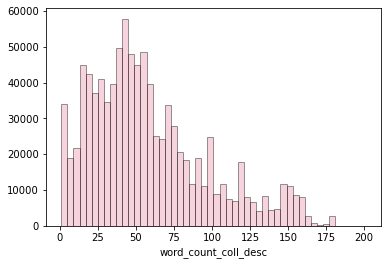

In [90]:
sns.distplot(elastic_df['word_count_coll_desc'], hist=True, kde=False, color = '#ec95ac',
             hist_kws={'edgecolor':'black'})

In [91]:
elastic_df['word_count_descr'] = elastic_df["description"].apply(lambda x: len(str(x).split(" ")))

<AxesSubplot:xlabel='word_count_descr'>

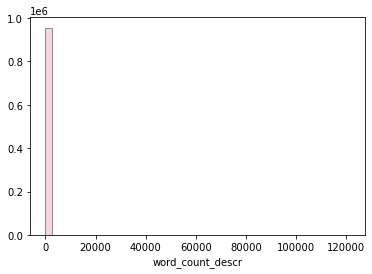

In [92]:
sns.distplot(elastic_df['word_count_descr'], hist=True, kde=False, color = '#ec95ac',
             hist_kws={'edgecolor':'black'})

In [93]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
instagram_follower,954544,0.999101
preview_path,289975,0.303511
img_path,240316,0.251534
price_crypto,29226,0.030590
contract_scheme,28574,0.029908
collection_name_tok,0,0.000000
creator_tok,0,0.000000
name_tok,0,0.000000
sale_time,0,0.000000
twitter_account,0,0.000000


In [94]:
max(elastic_df['sale_usd'])

6195956.0

## Lemmatisation (NLTK)

In [100]:
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import wordnet
#from nltk import word_tokenize
#from nltk import sent_tokenize
#from nltk import pos_tag

In [102]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [103]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') #filter out stop words
tag_dict = {
    "J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV
}
def lemma_text(text):
    new_text_array = []
    sentences = sent_tokenize(text.lower(), language = 'english')
    for sent in sentences:
        tokens = word_tokenize(sent, language = 'english')
        tok_pos = nltk.pos_tag(tokens)
        for tok, pos in tok_pos:
            if tok in stop_words:
                continue
            tok_type = pos[0].upper() # gets N for noun
            if tok_type in ['.', ',', ':']: # ignore punctuation
                continue
                
            mapped_type = tag_dict.get(tok_type, wordnet.NOUN) # default NOUN
            if tok.startswith('.'):
                tok = tok[1:] 
            if tok.endswith('.'):
                tok = tok[:-1]   
            new_text_array.append(lemmatizer.lemmatize(tok, mapped_type))
    return new_text_array #' '.join(new_text_array)

In [105]:
'Hallo.'[:-1]

'Hallo'

In [106]:
lemma_text('Ethereum Name. Service, ENS .domains are secure: bullshit rules! Hello.')

['ethereum',
 'name',
 'service',
 'ens',
 'domain',
 'secure',
 'bullshit',
 'rule',
 'hello']

In [95]:
import lemmatization
from multiprocessing import cpu_count, Pool

In [97]:
from time import time

In [96]:
cpu_count()

16

In [98]:
if __name__ ==  '__main__': 
    t = time()
    pool = Pool(cpu_count() - 4)
    elastic_df['collection_description'] = pool.map(lemmatization.lemma_text, elastic_df['collection_description'])
    print(elastic_df['collection_description'].head(5))
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))

0    [rug, radio, first, fully, decentralize, mediu...
1    [freedom, woofpack, adorable, algorithmically,...
2    [lil, pudgys, collection, randomly, generate, ...
3    [ethereum, name, service, en, domain, secure, ...
4    [nft, collection, reggae, culture, info, crypt...
Name: collection_description, dtype: object
Time: 8.72 mins


In [100]:
if __name__ ==  '__main__':
    t = time()
    pool = Pool(cpu_count() - 4)
    elastic_df['description'] = pool.map(lemmatization.lemma_text, elastic_df['description'])
    print(elastic_df['description'].head(5))
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))

0    [rug, radio, membership, pas, step, one, get, ...
1    [woofpack, generative, nft, collection, elusiv...
2    [lil, pudgys, collection, randomly, generate, ...
3                     [raisingcapital, eth, ens, name]
4    [cryptorasta, shannon, stone, doctor, new, yor...
Name: description, dtype: object
Time: 6.05 mins


In [102]:
#elastic_df['collection_description'] = elastic_df['collection_description'].apply(lemma_text)
#elastic_df['description'] = elastic_df['description'].apply(lemma_text)

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [103]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183405 entries, 0 to 200000
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   creator                  183405 non-null  object  
 1   price_crypto             183405 non-null  float64 
 2   sale_usd                 183405 non-null  float64 
 3   description              183405 non-null  object  
 4   is_animation             183405 non-null  bool    
 5   instagram                183405 non-null  object  
 6   name                     183405 non-null  object  
 7   collection_name          183405 non-null  object  
 8   collection_description   183405 non-null  object  
 9   contract_scheme          183405 non-null  category
 10  sale_token               183405 non-null  object  
 11  id                       183405 non-null  object  
 12  twitter                  183405 non-null  object  
 13  img_path                 136443 non-null  ob

in previe_path exist rows with NAs. 

In [101]:
elastic_df = elastic_df[elastic_df['preview_path'].isna() == False]

In [102]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665428 entries, 1 to 1075472
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   creator                  665428 non-null  object  
 1   price_crypto             645215 non-null  float64 
 2   sale_usd                 665428 non-null  float64 
 3   description              665428 non-null  object  
 4   is_animation             665428 non-null  bool    
 5   name                     665428 non-null  object  
 6   collection_name          665428 non-null  object  
 7   collection_description   665428 non-null  object  
 8   contract_scheme          645630 non-null  category
 9   sale_token               665428 non-null  object  
 10  id                       665428 non-null  object  
 11  instagram                665428 non-null  object  
 12  twitter                  665428 non-null  object  
 13  img_path                 665417 non-null  o

In [103]:
elastic_df = elastic_df.reset_index(drop=True)

## Word2Vec
 https://aegis4048.github.io/understanding_multi-dimensionality_in_vector_space_modeling
 https://www.kaggle.com/dmitryyemelyanov/word-vector-dimensionality-reduction-with-t-sne

In [104]:
from gensim.models import Word2Vec 
import multiprocessing
import gensim
from gensim.models.phrases import Phrases, Phraser

In [105]:
from time import time

In [106]:
t = time()
w2v = gensim.models.Word2Vec(elastic_df['collection_description'] + elastic_df['description'], 
                             min_count = 1, 
                             negative=2, 
                             size = 100,
                             window = 5, 
                             sg = 1, 
                             workers=14)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.44 mins


In [107]:
print(w2v)

Word2Vec(vocab=183793, size=100, alpha=0.025)


In [108]:
# summarise vocabulary
words = list(w2v.wv.vocab)
print(words[5:10])

['nft', 'collection', 'liberating', 'digitally', 'collectible']


In [109]:
w2v.wv.most_similar('nft',topn=20)

[('collection', 0.5840559005737305),
 ('nfts', 0.5536335110664368),
 ('upcoming', 0.5299100875854492),
 ('holder', 0.5217937231063843),
 ('coa', 0.5070294141769409),
 ('calaveras', 0.5034548044204712),
 ('project', 0.4939212203025818),
 ('wapuus', 0.48915427923202515),
 ('space', 0.4838426113128662),
 ('gianp', 0.48213011026382446),
 ('calabasas', 0.4816543459892273),
 ('cryptodude', 0.4791639447212219),
 ('stickies', 0.4786970317363739),
 ('metakey', 0.4782877266407013),
 ('enquire', 0.4775780141353607),
 ('networked', 0.47716522216796875),
 ('nessgraphic', 0.47483551502227783),
 ('art', 0.47457706928253174),
 ('kmc', 0.47395026683807373),
 ('furie', 0.4707784056663513)]

In [110]:
list(filter(lambda x: x.find('.') >= 0, words))

[]

In [114]:
elastic_df = elastic_df[elastic_df['img_path'].isna() == False]

In [116]:
elastic_df = elastic_df[elastic_df['contract_scheme'].isna() == False]

In [118]:
elastic_df.drop(['price_crypto', 'instagram_follower'], inplace=True, axis=1)

In [119]:
elastic_df = elastic_df.reset_index(drop=True)

In [8]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
creator,0,0.0
sale_usd,0,0.0
cat_usd,0,0.0
bin_log_usd,0,0.0
word_count_descr,0,0.0
word_count_coll_desc,0,0.0
twitter_tok,0,0.0
instagram_tok,0,0.0
collection_name_tok,0,0.0
creator_tok,0,0.0


In [7]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637325 entries, 0 to 645627
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   creator                  637325 non-null  object  
 1   sale_usd                 637325 non-null  float64 
 2   description              637325 non-null  object  
 3   is_animation             637325 non-null  bool    
 4   name                     637325 non-null  object  
 5   collection_name          637325 non-null  object  
 6   collection_description   637325 non-null  object  
 7   contract_scheme          637325 non-null  category
 8   sale_token               637325 non-null  object  
 9   id                       637325 non-null  object  
 10  instagram                637325 non-null  object  
 11  twitter                  637325 non-null  object  
 12  img_path                 637325 non-null  object  
 13  twitter_follower         637325 non-null  fl

In [4]:
import pickle

In [5]:
pickle_save_path = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\elastic_df.pkl'

In [164]:
with open(pickle_save_path,'wb') as path_name:
    pickle.dump(elastic_df, path_name) 

## Visualization: t-SNE

https://www.reneshbedre.com/blog/tsne.html
"
- The algorithms starts by calculating the probability of similarity of points in high-dimensional space and calculating the probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.
- It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.
- To measure the minimization of the sum of difference of conditional probability t-SNE minimizes the sum of Kullback-Leibler divergence of overall data points using a gradient descent method.
- In simpler terms, t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.
" - https://www.datacamp.com/community/tutorials/introduction-t-sne

In [6]:
with open(pickle_save_path,'rb') as path_name:
    elastic_df = pickle.load(path_name) 

In [117]:
X = w2v[w2v.wv.vocab]

C:\Users\bb1\AppData\Local\Temp/ipykernel_22280/3255277014.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = w2v[w2v.wv.vocab]


C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


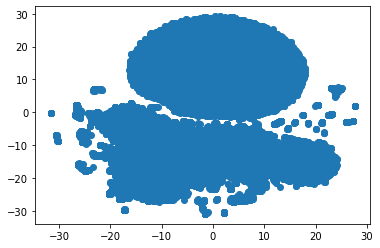

Time to train the model: 8.06 mins


In [118]:
from sklearn.manifold import TSNE
t = time()
tsne = TSNE(n_components=2, perplexity=50) #perplexity=30 by default, suggested values are between 6 and 60
Y = tsne.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [119]:
import random

In [120]:
random.sample(w2v.wv.index2word[0:200], 50)


['event',
 'original',
 'randomly',
 'learn',
 'find',
 'woman',
 'larva',
 'bore',
 'group',
 'mobile',
 'cool',
 'future',
 'launch',
 'design',
 'little',
 'project',
 'time',
 'need',
 'girl',
 'doods',
 'make',
 'dog',
 'combination',
 'club',
 'generative',
 'erc',
 'first',
 'kind',
 'baby',
 'drawn',
 'rare',
 'live',
 'culture',
 'fun',
 'able',
 'assemble',
 'detail',
 'world',
 'like',
 'lil',
 'store',
 'play',
 'cryptoskulls',
 'generate',
 'love',
 'amazing',
 'discord',
 'squad',
 'k',
 'genesis']

In [121]:
len(w2v.wv.index2word)

102880

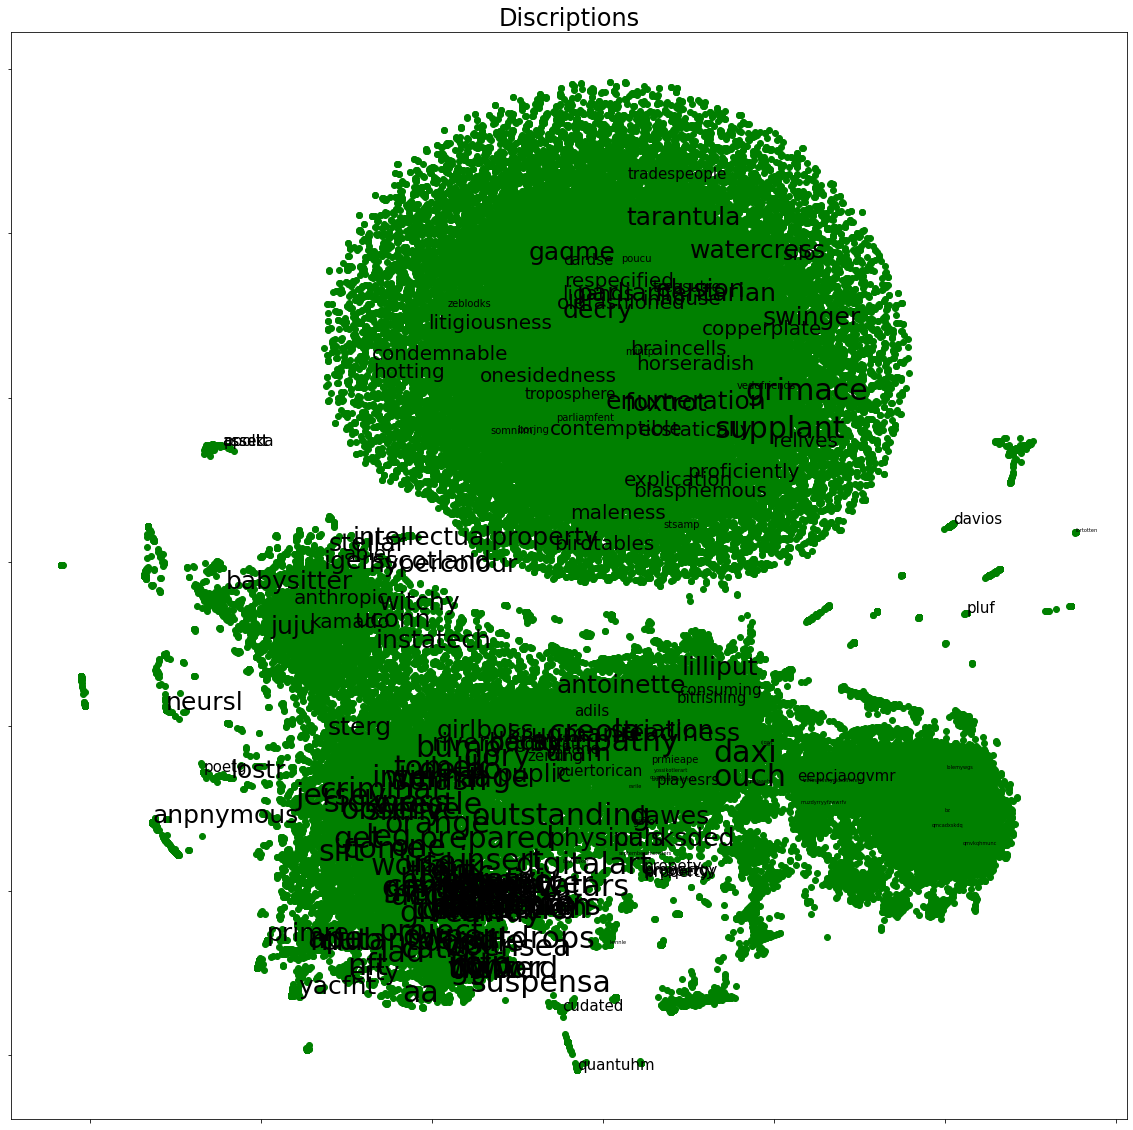

In [122]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
ax.plot(Y[:, 0], Y[:, 1], 'o',color='green')
ax.set_title('Discriptions')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks

sizes = [30, 25, 20, 15, 10, 5]
words = list(w2v.wv.vocab)
words_sorted = list(w2v.wv.index2word)
show_words = random.sample(w2v.wv.index2word[0:50000], 50)
for word in w2v.wv.index2word[0:50]:
    show_words.append(word)
for word in show_words:
    i = words.index(word)
    size = sizes[int((words_sorted.index(word) / len(words_sorted)) * len(sizes))]
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), fontsize=size)
    anti = w2v.wv.most_similar(word, topn=10001)[-1][0]
    #print(word, '---->', anti)
    i = words.index(anti)
    size = sizes[int((words_sorted.index(anti) / len(words_sorted)) * len(sizes))]
    plt.annotate(anti, xy=(Y[i, 0], Y[i, 1]), fontsize=size)
plt.show()
#plt.savefig('w2v.png')

In [242]:
#sizes = [30, 25, 20, 15, 10, 5]
#words_sorted = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
#words_sorted.index('j') % len(sizes)
#for w in words_sorted:
#    print(w, sizes[int((words_sorted.index(w) / len(words_sorted)) * len(sizes))])

a 30
b 30
c 30
d 25
e 25
f 20
g 20
h 15
i 15
j 10
k 10
l 5
m 5
